In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn import metrics
import joblib
import pickle
import h5py
import base64

In [ ]:
import os
path = (r'C://Users//HP//Tumor//Training_1//')
labels = ['glioma_tumor','meningioma_tumor','no_tumor', 'pituitary_tumor']

In [ ]:
import cv2
X = []
Y = []
for i in labels:
    pth='C://Users//HP//Tumor//Training_1//'+i
    for j in os.listdir(pth):
        img=cv2.imread(pth+'/'+j,0)
        img=cv2.resize(img,(250,270))
        X.append(img)
        Y.append(labels.index(i))

In [ ]:
X=np.array(X)
Y=np.array(Y)
X_updated=X.reshape(len(X),-1)

In [ ]:
X.shape,X_updated.shape

((3304, 270, 250), (3304, 67500))

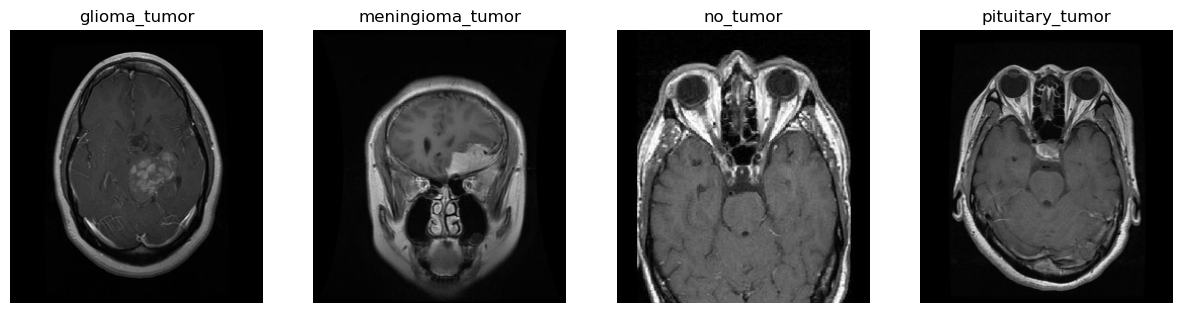

In [ ]:
label_indices = {}

# Loop through the data and find the first occurrence of each label
for idx, label in enumerate(Y):
    if label not in label_indices:
        label_indices[label] = idx

# Create a subplot with 1 row and as many columns as there are labels
fig, ax = plt.subplots(1, len(labels), figsize=(15,15 ))

# Loop through the label_indices dictionary and plot one image for each label
for label, idx in label_indices.items():
    ax[label].imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))  # OpenCV loads images in BGR, convert to RGB
    ax[label].set_title(labels[label])
    ax[label].axis('off')

plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_updated, Y, test_size=0.3, random_state=7)

In [ ]:
X_train.shape,X_test.shape

((2312, 67500), (992, 67500))

In [ ]:
print(X_train.max(),X_train.min())
print(X_test.max(),X_test.min())
xtrain=X_train/255
xtest=X_test/255
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')
lg=LogisticRegression(C=0.1)
lg.fit(xtrain,y_train)
Y_pred_lg= lg.predict(xtest)
testing_data_accuracy_lg=accuracy_score(Y_pred_lg,y_test)*100
print(testing_data_accuracy_lg)

79.43548387096774


In [ ]:
sv=SVC()
sv.fit(xtrain,y_train)
Y_pred_sv= sv.predict(xtest)
testing_data_accuracy_sv=accuracy_score(Y_pred_sv,y_test)*100
print(testing_data_accuracy_sv)

84.375


In [ ]:
rf=RandomForestClassifier(n_estimators= 10, criterion="entropy")
rf.fit(xtrain,y_train)
Y_pred_rf=rf.predict(xtest)
testing_data_accuracy_rf=accuracy_score(Y_pred_rf,y_test)*100
print(testing_data_accuracy_rf)


87.09677419354838


In [ ]:
confusion_rf = metrics.confusion_matrix(y_test, Y_pred_rf)
print("Confusion Matrix : \n" +str(confusion_rf))
TP = confusion_rf[1, 1]
TN = confusion_rf[0, 0]
FP = confusion_rf[0, 1]
FN = confusion_rf[1, 0]

Confusion Matrix : 
[[216  35   0   1]
 [ 27 179  23  14]
 [  2   6 230   3]
 [  5   7   5 239]]


In [ ]:
print(classification_report(y_test,Y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       252
           1       0.79      0.74      0.76       243
           2       0.89      0.95      0.92       241
           3       0.93      0.93      0.93       256

    accuracy                           0.87       992
   macro avg       0.87      0.87      0.87       992
weighted avg       0.87      0.87      0.87       992



In [ ]:
Recall = (TP / float(FN + TP))*100
print("Recall : " + str(Recall))
Precision = (TP / float(TP + FP))*100
print("Precision : " + str(Precision))

Recall : 86.89320388349515
Precision : 83.64485981308411


In [ ]:
joblib.dump(rf, 'rf.pkl')

['rf.pkl']

In [ ]:
from ipywidgets import widgets, FileUpload, Button, Output, VBox
import io
from PIL import Image
import cv2
import numpy as np
import joblib

# Load the pre-trained RandomForest model
rf_model = joblib.load('rf.pkl')

# Define class labels
# Update the class_labels in the code
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


def preprocess_image(img):
    # Resize and preprocess the image for the model
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (150, 150))
    img_flat = img.flatten().reshape(1, -1)  # Flatten the image
    return img_flat

def img_pred(upload, model, labels):
    upload_tuple = upload.value
    if isinstance(upload_tuple, tuple) and len(upload_tuple) > 0:
        upload_dict = upload_tuple[0]
        if 'content' in upload_dict:
            img_content = upload_dict['content']
            img = Image.open(io.BytesIO(img_content))
            img = preprocess_image(img)
            #print(f"Debug: Flattened Image Shape: {img.shape}")

            prediction = model.predict_proba(img)
            #print(f"Debug: Raw Prediction Probabilities: {prediction}")

            # Use np.argmax to get the index of the maximum probability
            class_index = np.argmax(prediction)

            if 0 <= class_index < len(labels):
                predicted_class = labels[class_index]
                print(f'The model predicts: {predicted_class}')
            else:
                print("Invalid class index.")
        else:
            print("Content not found in upload")
    else:
        print("Unexpected data structure:", upload_tuple)


uploader = FileUpload()
display(uploader)

button = Button(description='Predict')
output = Output()

def on_button_clicked(_):
    with output:
        output.clear_output()
        try:
            img_pred(uploader, rf_model, class_labels)
        except Exception as e:
            print('No Image Uploaded/Invalid Image File:', str(e))

button.on_click(on_button_clicked)
display(VBox([button, output]))


FileUpload(value=(), description='Upload')

In [ ]:
#GRAPHICAL RESULTS